In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
from tqdm import tqdm
from scipy import optimize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import warnings
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

### ALGORITHMS

##### LOGISTIC REGRESSION

In [2]:
class _LogisticRegression:
    def __init__(self, learningRate, tolerance, maxIteration):
        self.learningRate = learningRate
        self.tolerance= tolerance
        self.maxIteration = maxIteration
    
    def add_x0(self, X):
        """
        @X: numpy matrix, dataset
        @does: add a bias term to the data
        @returns: numpy matrix
        """
        return np.column_stack([np.ones(X.shape[0],1), X])
    
    def sigmoid(self, Z):
        """
        @Z: Array of values
        @does: converts the values to between 0 and 1
        @returns: modified array
        """
        
        sig = 1/(1+np.exp(-Z))
        
        return sig
    
    
    def cost_function(self, X, y):
        """
        @X: numpy matrix, dataset
        @y : numpy array, vector
        @does: finds the error
        @returns: float
        """
        
        sig = self.sigmoid(X.dot(self.w))
        pred_ =  np.log(np.ones(X.shape[0])+np.exp(sig))- X.dot(self.w).dot(y)
        cost = pred_.sum()
        
        return cost
    
    def gradient(self, X, y):
        """
        @X: numpy matrix, dataset
        @y : numpy array, vector
        @does: finds the gradient for coefficients
        @returns: array
        """
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig - y).dot(X)
        return grad
    
    def gradient_descent(self, X, y):
        """
        @X: numpy matrix, dataset
        @y : numpy array, vector
        @does: checks if change in cost is lesser than tolerance
        @returns: 
        """
        
        cost_sequence = []
        
        last_cost = float('inf')
        
        tolerance_counter = 0
        
        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_cost = self.cost_function(X, y)
            diff = last_cost-current_cost
            last_cost = current_cost
            cost_sequence.append(current_cost)
            
            
            if abs(diff) < self.tolerance:               
                tolerance_counter += 1   
                break
            
                
            
        
        self.plot_cost(cost_sequence)
        
        return
    
    def plot_cost(self,cost_sequence):
        """
        @X: numpy matrix, dataset
        @does: plot of the cost sequence
        """
        s= np.array(cost_sequence)
        t=np.arange(s.size)
        
        fig, ax = plt.subplots()
        ax.plot(t,s)
        
        ax.set(xlabel = 'iterations',ylabel='cost', title = 'cost Trend')
        ax.grid()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2,shadow =True) ##CHECK WHAT HAPPENED HERE
        plt.show()
    
    def predict(self, X):
        """
        @X: numpy matrix, dataset
        @does: uses sigmoid function to return values between 0 and 1
        @returns: array of values
        """
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)
    
    def evaluate(self, y, y_hat):
        """
        @y : numpy array, target values vector
        @y_hat : predicted values vector
        @does: evaluates thew performance of the model 
        @returns: accuracy,recall,precision
        """
        y = (y == 1)
        y_hat = (y_hat == 1)
        
        accuracy = (y == y_hat).sum()/y.size
        precision = (y & y_hat).sum()/y_hat.sum()
        recall = (y & y_hat).sum()/y.sum()
        
        return accuracy,recall,precision
    
    def run_model(self,X_train,y_train):
        """
        @X_train: numpy matrix, dataset training
        @y_train : numpy array, vector training
        @does: finds the gradient
        @returns: float
        """
        self.w = np.ones(X_train.shape[1], dtype =np.float64) * 0
        self.gradient_descent(X_train,y_train)
        
        print(self.w)

##### KERNEL SVM

In [3]:
class KernelSvmClassifier:
    
    def __init__(self, C, kernel):
        self.C = C                               
        self.kernel = kernel          # <---
        self.alpha = None
        self.supportVectors = None
    
    def fit(self, X, y):
        """
        @X: numpy matrix, dataset 
        @y : numpy array, target vector 
        @does: fits the kernel model
        @returns: 
        """
        N = len(y)
        # --->
        # Gram matrix of h(x) y
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        for i in tqdm(range(n_samples)):
            for j in range(n_samples):
                K[i,j] = self.kernel(X.iloc[i], X.iloc[j])    
        yp = y.values.reshape(-1, 1)
        GramHXy = K * np.matmul(yp, yp.T) 
        
        def Ld0(G, alpha):
            """
            @G: numpy matrix
            @alpha : numpy array
            @does: Lagrange dual problem
            @returns: float
            """
            
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        
        def Ld0dAlpha(G, alpha):
            """
            @G: numpy matrix
            @alpha : numpy array 
            @does: Partial derivate of Ld on alpha
            @returns: array of floats
            """
            
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramHXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramHXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        
        epsilon = 1e-8
        supportIndices = self.alpha > epsilon
        self.supportVectors = X[supportIndices]
        self.supportAlphaY = y[supportIndices] * self.alpha[supportIndices]
    
    def predict(self, X): 
        """ 
        @X : numpy matrix, dataset 
        @does : Predict y values in {-1, 1}
        @returns: predicted values array
        """
        # --->
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s, x), 1, self.supportVectors)
            x2 = x1 * self.supportAlphaY
            return np.sum(x2)
        
        d = np.apply_along_axis(predict1, 1, X)
        return 2 * (d > 0) - 1
    
   
    

In [4]:
def GRBF(x1, x2):
    """ 
    @x1 : numpy array
    @x2 : numpy array
    @does : implement Gaussian Radial Basis Function
    @returns: float
    """
    diff = x1 - x2
    return np.exp(-np.dot(diff, diff) * len(x1) / 2)

##### FEATURE SELECTION _ STEPWISE

In [5]:
warnings.filterwarnings("ignore")
def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

EVALUATION METRIC SVM

In [6]:
def evaluate_svm( y, y_hat):
    """
    @y : numpy array, target values vector
    @y_hat : predicted values vector
    @does: evaluates thew performance of the model 
    @returns: accuracy,recall,precision,f1   
    """
    accuracy = (y == y_hat).sum()/y.size
    precision = ((y==1) & (y_hat==1)).sum()/(y_hat==1).sum()
    recall = ((y==1) & (y_hat==1)).sum()/(y==1).sum()
    f1 = 2*((precision*recall)/(precision+recall)) 
        
    return accuracy,recall,precision,f1  

##### DATASET DEFINED

The dataset used for this project was obtained from the UCI Machine Learnign Repository. The dataset is called the "
Bank Marketing Data Set". The link for the dataset is - https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The team downloaded the zip file and used the bank-full.csv. The file has been added to a google drive the link has been used for the pandas dataframe. 

In [ ]:
## data = pd.read_csv('bank-full.csv',sep=';') ## Using this cell or the next one, data is the same.

In [7]:
url = 'https://drive.google.com/file/d/18Mdt-j-Jo1a05re0SNz2z8NZaxNher_p/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path,sep=';')

In [8]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


*****CHECKING FOR CLASS IMBALANCE*****

In [9]:
print('Class Ratio:',
       sum(data['y']=='yes')/len(data['y']))

Class Ratio: 0.11698480458295547


In [10]:
print('Class Ratio:',
       sum(data['y']=='no')/len(data['y']))

Class Ratio: 0.8830151954170445


Pdays, day and duration have been dropped as they were not adding much information to the model due to their either their highly correlated meaning to another variable. In case of duration, this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [11]:
data = data.drop(['pdays','day','duration'],axis=1)
data.shape

(45211, 14)

##### WORKING WITH CATEGORICAL VARIABLES

In [12]:
data['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [13]:
data['job'].value_counts() ##one_hot encoding 

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [14]:
data['marital'].value_counts()   ##performing ordinal encoding for marital column

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [15]:
data.loc[data['marital']=="single",'marital']=0
data.loc[data['marital']=="married",'marital']=1
data.loc[data['marital']=="divorced",'marital']=2

In [16]:
data['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

<AxesSubplot:xlabel='education', ylabel='count'>

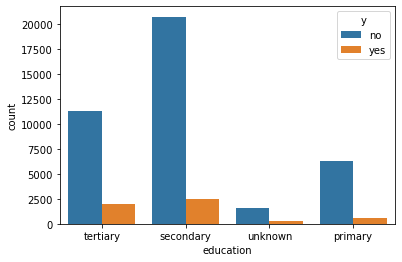

In [17]:
sns.countplot(data['education'], hue = data['y'])

There is no specific relation for the education column  

In [18]:
data.loc[data['education']=='unknown','education']=0
data.loc[data['education']=='primary','education']=1
data.loc[data['education']=='secondary','education']=2
data.loc[data['education']=='tertiary','education']=3

In [19]:
data['default'].value_counts() ###ordinal encoding

no     44396
yes      815
Name: default, dtype: int64

In [20]:
data.loc[data['default']=="no",'default']=0
data.loc[data['default']=="yes",'default']=1

In [21]:
data['default'].head()

0    0
1    0
2    0
3    0
4    0
Name: default, dtype: object

In [22]:
data['housing'].value_counts() ##ordinal encoding

yes    25130
no     20081
Name: housing, dtype: int64

In [23]:
data.loc[data['housing']=="no",'housing']=0
data.loc[data['housing']=="yes",'housing']=1
data['housing'].head()

0    1
1    1
2    1
3    1
4    0
Name: housing, dtype: object

In [24]:
data['loan'].value_counts() ##ordinal encoding

no     37967
yes     7244
Name: loan, dtype: int64

In [25]:
data.loc[data['loan']=="no",'loan']=0
data.loc[data['loan']=="yes",'loan']=1
data['loan'].head()

0    0
1    0
2    1
3    0
4    0
Name: loan, dtype: object

In [26]:
data['contact'].value_counts()  ##one-hot encoding

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [27]:
data['month'].value_counts()  ##ordinal encoding

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

<AxesSubplot:xlabel='month', ylabel='count'>

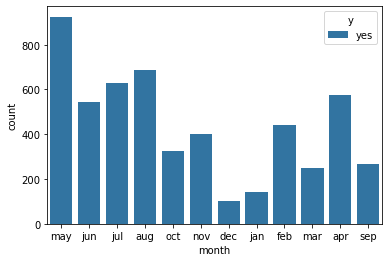

In [28]:
k=data[data['y']=="yes"]
sns.countplot(k['month'], hue = k['y'])

<AxesSubplot:xlabel='month', ylabel='count'>

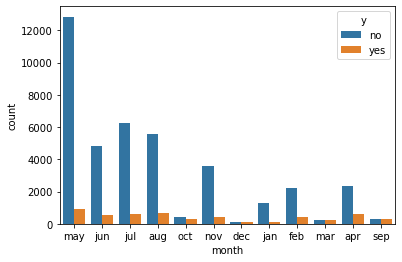

In [29]:
sns.countplot(data['month'], hue = data['y'])

In [30]:
k['month'].value_counts()

may    925
aug    688
jul    627
apr    577
jun    546
feb    441
nov    403
oct    323
sep    269
mar    248
jan    142
dec    100
Name: month, dtype: int64

Giving priority based on the number of yes in a month

In [31]:
Month_replacement = {"month": {"may": 1, "aug": 2,"jul":3,"apr":4,"jun":5,"feb":6,"nov":7,"oct":8,"sep":9,"mar":10,"jan":11,
                               "dec":12}}

data=data.replace(Month_replacement)

<AxesSubplot:xlabel='poutcome', ylabel='count'>

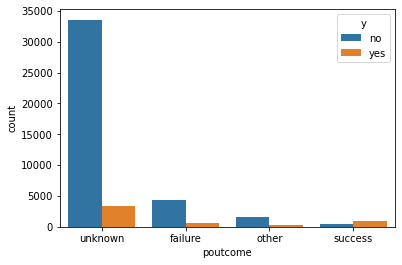

In [32]:
sns.countplot(data['poutcome'], hue = data['y'])

Here there are 4 categories. Combining the unknown and other types into a single type. 

In [33]:
data['poutcome'].value_counts() ##ordinal 

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [34]:
###modifying columns based on yes class. Giving priority to unknown and other

poutcome_replacement={"poutcome":{"unknown":1,"other":1,"success":2,"failure":3}}

data=data.replace(poutcome_replacement)



In [35]:
data['y'].value_counts() ##ordinal encoding

no     39922
yes     5289
Name: y, dtype: int64

In [36]:
data.loc[data['y']=="no",'y']= 0
data.loc[data['y']=="yes",'y']= 1
data['y'].head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: object

In [37]:
data = pd.get_dummies(data = data, columns = ['job','contact'],drop_first = True)
              

In [38]:
data.head()

,age,marital,education,default,balance,housing,loan,month,campaign,previous,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_telephone,contact_unknown
0,58,1,3,0,2143,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
1,44,0,2,0,29,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
2,33,1,2,0,2,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,47,1,0,0,1506,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,33,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1


In [39]:
data['y']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: object

In [40]:
data[['campaign','previous','balance']].describe()

,campaign,previous,balance
count,45211.000000,45211.000000,45211.000000
mean,2.763841,0.580323,1362.272058
std,3.098021,2.303441,3044.765829
min,1.000000,0.000000,-8019.000000
25%,1.000000,0.000000,72.000000
50%,2.000000,0.000000,448.000000
75%,3.000000,0.000000,1428.000000
max,63.000000,275.000000,102127.000000


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                45211 non-null  int64 
 1   marital            45211 non-null  object
 2   education          45211 non-null  object
 3   default            45211 non-null  object
 4   balance            45211 non-null  int64 
 5   housing            45211 non-null  object
 6   loan               45211 non-null  object
 7   month              45211 non-null  int64 
 8   campaign           45211 non-null  int64 
 9   previous           45211 non-null  int64 
 10  poutcome           45211 non-null  int64 
 11  y                  45211 non-null  object
 12  job_blue-collar    45211 non-null  uint8 
 13  job_entrepreneur   45211 non-null  uint8 
 14  job_housemaid      45211 non-null  uint8 
 15  job_management     45211 non-null  uint8 
 16  job_retired        45211 non-null  uint8

In [42]:
data['y']=data['y'].astype(int)
data['marital']=data['marital'].astype(int)
data['education']=data['education'].astype(int)
data['default']=data['default'].astype(int)
data['housing']=data['housing'].astype(int)
data['loan']=data['loan'].astype(int)

In [43]:
data.corr()

,age,marital,education,default,balance,housing,loan,month,campaign,previous,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_telephone,contact_unknown
age,1.000000,0.403240,-0.173615,-0.017879,0.097783,-0.185513,-0.015655,0.086378,0.004760,0.001288,...,-0.023571,0.447378,-0.008093,-0.065780,-0.197302,-0.068632,0.000412,0.050200,0.170349,-0.020132
marital,0.403240,1.000000,-0.095415,0.007023,-0.002122,0.016096,0.046893,-0.014601,0.008994,-0.014973,...,-0.022322,0.116171,-0.008154,0.006009,-0.182337,-0.040927,-0.002490,-0.001232,0.020524,0.033310
education,-0.173615,-0.095415,1.000000,-0.009035,0.050572,-0.038689,0.004307,0.046916,0.000194,0.025295,...,0.450484,-0.104710,0.081914,-0.068282,-0.040606,0.065809,-0.017802,-0.101192,-0.075152,-0.129842
default,-0.017879,0.007023,-0.009035,1.000000,-0.066745,-0.006025,0.077234,-0.015682,0.016822,-0.018329,...,-0.002655,-0.011290,0.004107,0.000068,-0.016222,-0.003089,0.006470,-0.006669,-0.017208,0.019933
balance,0.097783,-0.002122,0.050572,-0.066745,1.000000,-0.068768,-0.084350,0.093798,-0.014578,0.016674,...,0.067797,0.046900,0.017850,-0.038151,0.001233,-0.016183,0.009023,0.010784,0.037999,-0.037331
housing,-0.185513,0.016096,-0.038689,-0.006025,-0.068768,1.000000,0.041323,-0.244022,-0.023599,0.037076,...,-0.063382,-0.156633,-0.027319,0.070435,-0.085066,-0.012823,-0.048229,-0.075023,-0.080822,0.208409
loan,-0.015655,0.046893,0.004307,0.077234,-0.084350,0.041323,1.000000,-0.014244,0.009980,-0.011043,...,-0.038904,-0.014861,-0.007882,0.035575,-0.058503,0.014798,-0.035961,-0.031943,-0.013183,-0.007211
month,0.086378,-0.014601,0.046916,-0.015682,0.093798,-0.244022,-0.014244,1.000000,-0.097368,0.098699,...,0.042730,0.080455,0.029870,-0.034767,0.045998,-0.028338,0.072778,0.025045,0.086025,-0.252277
campaign,0.004760,0.008994,0.000194,0.016822,-0.014578,-0.023599,0.009980,-0.097368,1.000000,-0.032855,...,0.016686,-0.030913,0.005479,-0.004671,-0.021813,0.020739,-0.018448,0.014091,0.053895,0.004853
previous,0.001288,-0.014973,0.025295,-0.018329,0.016674,0.037076,-0.011043,0.098699,-0.032855,1.000000,...,0.019579,0.005818,-0.002371,-0.010926,0.023556,-0.001123,-0.008504,-0.009068,0.028097,-0.154162


Dealing with Campaign column

<AxesSubplot:xlabel='campaign', ylabel='Density'>

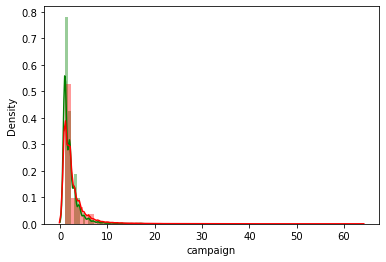

In [44]:
sns.distplot(data[data['y']==1]["campaign"],color = "green")
sns.distplot(data[data['y']==0]['campaign'], color = "red")

(array([4.2882e+04, 1.6220e+03, 4.2000e+02, 1.6500e+02, 7.5000e+01,
        3.3000e+01, 7.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([ 1. ,  7.2, 13.4, 19.6, 25.8, 32. , 38.2, 44.4, 50.6, 56.8, 63. ]),
 <BarContainer object of 10 artists>)

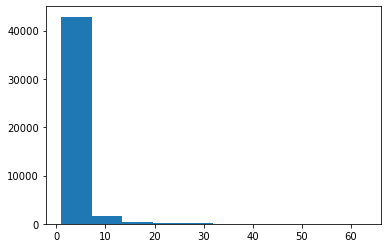

In [45]:
plt.hist(data['campaign'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc83b801fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc83b80f6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc83b801c70>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc83b80fd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc83b81b130>],
 'means': []}

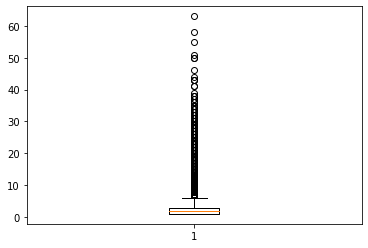

In [46]:
plt.boxplot(data['campaign'])

As we can see from the above plot that there are many outliers. Using quantile ranges we are detecting the outliers

Outlier detection: lower bound: 25th Quatile - IQR1.5 Upper bound: IQR1.5+ 75th Quatile

Link referred: https://www.thoughtco.com/what-is-an-outlier-3126227

Calculating based on the above formula

Lower bound: 1-3 = -2 Upper bound: 3+3 = 6

In [47]:
data['campaign'].describe()


count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [48]:
IQR=2
IQR*1.5

3.0

In [49]:
###mean imputing the values less thta -2 and greater than 6
data.loc[data['campaign']>6,'campaign']=2.76


In [50]:
data['campaign'].describe()

count    45211.000000
mean         2.172649
std          1.280303
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: campaign, dtype: float64

<AxesSubplot:xlabel='balance', ylabel='Density'>

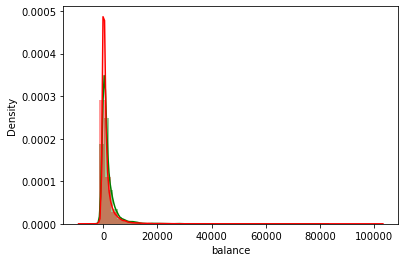

In [51]:
sns.distplot(data[data['y']==1]['balance'],color = "green")
sns.distplot(data[data['y']==0]['balance'], color = "red")

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc83b471c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc83b47c310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc83b4718b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc83b47c9d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc83b47cd30>],
 'means': []}

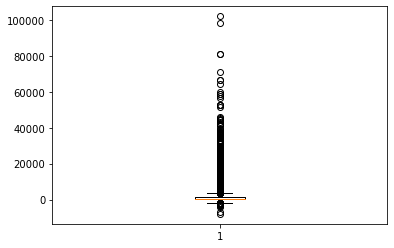

In [52]:
plt.boxplot(data['balance'])

In [53]:
data['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [54]:
data['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [55]:
x = data[['age','balance']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df

,0,1
0,0.519481,0.092259
1,0.337662,0.073067
2,0.194805,0.072822
3,0.376623,0.086476
4,0.194805,0.072812
...,...,...
45206,0.428571,0.080293
45207,0.688312,0.088501
45208,0.701299,0.124689
45209,0.506494,0.078868


In [56]:
df.columns = ['age','balance']
df.head()

,age,balance
0,0.519481,0.092259
1,0.337662,0.073067
2,0.194805,0.072822
3,0.376623,0.086476
4,0.194805,0.072812


In [57]:
data[['age','balance']]=df

<AxesSubplot:xlabel='previous', ylabel='Density'>

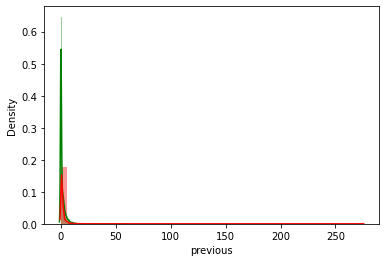

In [58]:
sns.distplot(data[data['y']==1]['previous'],color = "green")
sns.distplot(data[data['y']==0]['previous'], color = "red")

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc83d03d7f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc83d03deb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc83d03d490>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc83d0495b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc83d049910>],
 'means': []}

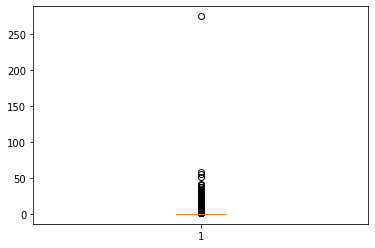

In [59]:
plt.boxplot(data['previous'])

In [60]:
data['previous'].describe()

count    45211.000000
mean         0.580323
std          2.303441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

The column previous states whether the customer is previously contacted or not. If contacted how many times were they contacted before the current call. Replacing other values with +1 for values other than 0 and converting the column as categorical.

In [61]:
data.loc[data['previous']>0 ,'previous']= 1

In [62]:
data['previous'].describe()

count    45211.000000
mean         0.182633
std          0.386369
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: previous, dtype: float64

Preprocessing is done and the next step is to split the data into training, testing using stratified split

*****STRATIFIED SPLLITING*****

WITHOUT FEATURE SELECTION

In [63]:
tr_ts = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
for train_index, test_index in tr_ts.split(data, data["y"]):
    train = data.iloc[train_index]
    test  = data.iloc[test_index]

In [64]:
X_train = train.drop('y', axis=1)
y_train = train['y']

In [65]:
X_test = test.drop('y', axis=1)
y_test = test['y']

#### LOGISTIC REGRESSION

100%|██████████| 10000/10000 [01:25<00:00, 117.61it/s]
No handles with labels found to put in legend.


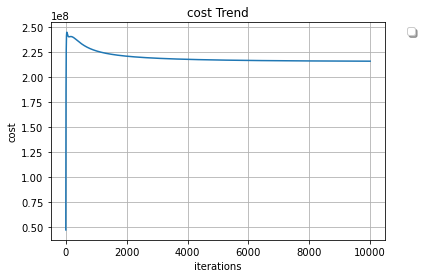

age                 -0.348387
marital             -0.209778
education           -0.106280
default             -0.142582
balance             -0.094849
housing             -0.731848
loan                -0.619327
month                0.033879
campaign            -0.225609
previous             1.389115
poutcome            -0.526806
job_blue-collar     -0.502989
job_entrepreneur    -0.245655
job_housemaid       -0.327274
job_management      -0.035936
job_retired          0.376116
job_self-employed   -0.132265
job_services        -0.350471
job_student          0.153169
job_technician      -0.304443
job_unemployed      -0.073745
job_unknown         -0.072214
contact_telephone   -0.212623
contact_unknown     -1.062770
dtype: float64


In [66]:
lr1 = _LogisticRegression(tolerance= 0.0000001, learningRate =  0.1e-5, maxIteration = 10000)
lr1.run_model(X_train,np.array(y_train, dtype=int))

In [67]:
y_hat = lr1.predict(X_test)
accuracy,recall,precision = lr1.evaluate(np.array(y_test, dtype=int), y_hat)
f1 = 2*((precision*recall)/(precision+recall))
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.8825975404759798
recall :  0.04084720121028744
precision :  0.4778761061946903
f1 :  0.07526132404181184


#### SVM (KERNEL= RBF)

In [68]:
for i in range(len(y_train)):
    if y_train.iloc[i] == 1:
        y_train.iloc[i] = 1
    else:
        y_train.iloc[i] = -1 

In [69]:
for i in range(len(y_test)):
    if y_test.iloc[i] == 1:
        y_test.iloc[i] = 1
    else:
        y_test.iloc[i] = -1 

In [70]:
model_SVM = KernelSvmClassifier(C=1000, kernel=GRBF)

Time taken increase as training size increases, so for saving time, training has been done with smaller dataset with taking the first 'n' rows of training data. With right computational power, training can be done in a more refined manner.

In [71]:
model_SVM.fit(X_train.iloc[0:100],y_train.head(100)) ## FIRST 100 ROWS

100%|██████████| 100/100 [00:03<00:00, 25.59it/s]


In [72]:
y_pred=model_SVM.predict(X_test)

In [73]:
accuracy,recall,precision,f1 = evaluate_svm(y_test,y_pred)
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.7897018490666194
recall :  0.2806354009077156
precision :  0.20645520311630494
f1 :  0.23789676178262262


In [74]:
model_SVM.fit(X_train.iloc[0:500],y_train.head(500)) ## FIRST 500 ROWS

100%|██████████| 500/500 [01:35<00:00,  5.22it/s]


In [75]:
y_pred=model_SVM.predict(X_test)

In [76]:
accuracy,recall,precision,f1 = evaluate_svm(y_test,y_pred)
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.7986375298593293
recall :  0.24962178517397882
precision :  0.20446096654275092
f1 :  0.22479564032697547


In [77]:
model_SVM.fit(X_train.iloc[0:1500],y_train.head(1500))  ## FIRST 1500 ROWS

100%|██████████| 1500/1500 [13:49<00:00,  1.81it/s]


In [78]:
y_pred=model_SVM.predict(X_test)

In [79]:
accuracy,recall,precision,f1 = evaluate_svm(y_test,y_pred)
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.7897018490666194
recall :  0.2934947049924357
precision :  0.21190606226105954
f1 :  0.2461148112908341


##### WITH FEATURE SELECTION

In [80]:
X = data.drop('y', axis=1)
y = data['y']

In [81]:
X.shape

(45211, 24)

In [82]:
best_features=stepwise_selection(X,y)


In [83]:
best_features

['previous',
 'housing',
 'month',
 'poutcome',
 'contact_unknown',
 'loan',
 'campaign',
 'job_retired',
 'job_student',
 'education',
 'marital',
 'balance',
 'contact_telephone',
 'job_unemployed',
 'job_housemaid',
 'job_entrepreneur',
 'job_blue-collar']

In [84]:
X_best = X[best_features]

In [85]:
X_best.shape

(45211, 17)

In [86]:
new_data=X_best.join(y)

In [87]:
new_data

,previous,housing,month,poutcome,contact_unknown,loan,campaign,job_retired,job_student,education,marital,balance,contact_telephone,job_unemployed,job_housemaid,job_entrepreneur,job_blue-collar,y
0,0,1,1,1,1,0,1.0,0,0,3,1,0.092259,0,0,0,0,0,0
1,0,1,1,1,1,0,1.0,0,0,2,0,0.073067,0,0,0,0,0,0
2,0,1,1,1,1,1,1.0,0,0,2,1,0.072822,0,0,0,1,0,0
3,0,1,1,1,1,0,1.0,0,0,0,1,0.086476,0,0,0,0,1,0
4,0,0,1,1,1,0,1.0,0,0,0,0,0.072812,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0,0,7,1,0,0,3.0,0,0,3,1,0.080293,0,0,0,0,0,1
45207,0,0,7,1,0,0,2.0,1,0,1,2,0.088501,0,0,0,0,0,1
45208,1,0,7,2,0,0,5.0,1,0,2,1,0.124689,0,0,0,0,0,1
45209,0,0,7,1,0,0,4.0,0,0,2,1,0.078868,1,0,0,0,1,0


In [88]:
tr_ts = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
for train_index, test_index in tr_ts.split(new_data, new_data["y"]):
    train = new_data.iloc[train_index]
    test  = new_data.iloc[test_index]

In [89]:
print('Class Ratio:',
       sum(train['y'])/len(train['y']))

Class Ratio: 0.1169930399905627


In [90]:
print('Class Ratio:',
       sum(test['y']==1)/len(test['y']))

Class Ratio: 0.1169600990887375


In [91]:
X_train = train.drop('y', axis=1)
y_train = train['y']
X_test = test.drop('y', axis=1)
y_test = test['y']

100%|██████████| 10000/10000 [01:36<00:00, 104.06it/s]
No handles with labels found to put in legend.


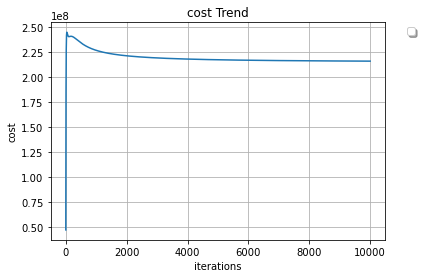

previous             1.431380
housing             -0.754997
month                0.028506
poutcome            -0.572032
contact_unknown     -1.090294
loan                -0.642169
campaign            -0.248451
job_retired          0.377369
job_student          0.212840
education           -0.124633
marital             -0.258331
balance             -0.114865
contact_telephone   -0.229434
job_unemployed      -0.030033
job_housemaid       -0.300417
job_entrepreneur    -0.206425
job_blue-collar     -0.417379
dtype: float64


In [92]:
lr1 = _LogisticRegression(tolerance= 0.0000001, learningRate =  0.1e-5, maxIteration = 10000)
lr1.run_model(X_train,np.array(y_train, dtype=int))

In [93]:
y_hat = lr1.predict(X_test)
accuracy,recall,precision = lr1.evaluate(np.array(y_test, dtype=int), y_hat)
f1 = 2*((precision*recall)/(precision+recall))
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.8828629567371494
recall :  0.04462934947049924
precision :  0.49166666666666664
f1 :  0.08183079056865464


#### SVM KERNEL RBF

In [94]:
for i in range(len(y_train)):
    if y_train.iloc[i] == 1:
        y_train.iloc[i] = 1
    else:
        y_train.iloc[i] = -1   

In [95]:
for i in range(len(y_test)):
    if y_test.iloc[i] == 1:
        y_test.iloc[i] = 1
    else:
        y_test.iloc[i] = -1 

In [96]:
model_BestFeatures = KernelSvmClassifier(C=1000, kernel=GRBF)

In [97]:
model_BestFeatures.fit(X_train.iloc[0:100],y_train.head(100))

100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


In [98]:
y_pred=model_BestFeatures.predict(X_test)

In [99]:
accuracy,recall,precision,f1 = evaluate_svm(y_test,y_pred)
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.769884101565956
recall :  0.31921331316187596
precision :  0.1987753179463024
f1 :  0.24499274310595065


In [100]:
model_BestFeatures.fit(X_train.iloc[0:500],y_train.head(500)) ## FIRST 500 rows

100%|██████████| 500/500 [01:27<00:00,  5.71it/s]


In [101]:
y_pred=model_BestFeatures.predict(X_test)

In [102]:
accuracy,recall,precision,f1 = evaluate_svm(y_test,y_pred)
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.7932407325488808
recall :  0.26626323751891073
precision :  0.20477021524141942
f1 :  0.23150279513317987


In [103]:
model_BestFeatures.fit(X_train.iloc[0:1500],y_train.head(1500)) ##FIRST 1500 rows

100%|██████████| 1500/1500 [13:17<00:00,  1.88it/s]


In [104]:
y_pred=model_BestFeatures.predict(X_test)

In [105]:
accuracy,recall,precision,f1 = evaluate_svm(y_test,y_pred)
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.7933292046359374
recall :  0.3154311649016641
precision :  0.22564935064935066
f1 :  0.2630914826498422


### USING SMOTENC

In [106]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   previous           45211 non-null  int64  
 1   housing            45211 non-null  int64  
 2   month              45211 non-null  int64  
 3   poutcome           45211 non-null  int64  
 4   contact_unknown    45211 non-null  uint8  
 5   loan               45211 non-null  int64  
 6   campaign           45211 non-null  float64
 7   job_retired        45211 non-null  uint8  
 8   job_student        45211 non-null  uint8  
 9   education          45211 non-null  int64  
 10  marital            45211 non-null  int64  
 11  balance            45211 non-null  float64
 12  contact_telephone  45211 non-null  uint8  
 13  job_unemployed     45211 non-null  uint8  
 14  job_housemaid      45211 non-null  uint8  
 15  job_entrepreneur   45211 non-null  uint8  
 16  job_blue-collar    452

In [107]:
from imblearn.over_sampling import SMOTENC
X=new_data.drop('y', axis=1)
y=new_data['y']
smote_nc = SMOTENC(categorical_features=[0,1,2,3,5,7,8,9,10,11,12,13,14,15,16], random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

In [108]:
overSampled_data=X_resampled.join(y_resampled)

In [109]:
overSampled_data

,previous,housing,month,poutcome,contact_unknown,loan,campaign,job_retired,job_student,education,marital,balance,contact_telephone,job_unemployed,job_housemaid,job_entrepreneur,job_blue-collar,y
0,0,1,1,1,1,0,1.000000,0,0,3,1,0.092259,0,0,0,0,0,0
1,0,1,1,1,1,0,1.000000,0,0,2,0,0.073067,0,0,0,0,0,0
2,0,1,1,1,1,1,1.000000,0,0,2,1,0.072822,0,0,0,1,0,0
3,0,1,1,1,1,0,1.000000,0,0,0,1,0.086476,0,0,0,0,1,0
4,0,0,1,1,1,0,1.000000,0,0,0,0,0.072812,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79839,0,0,6,1,0,0,2.785126,0,0,2,1,0.072849,0,0,0,0,1,1
79840,0,0,3,1,0,0,1.000000,0,0,2,1,0.072803,0,0,0,0,0,1
79841,1,0,4,3,0,0,1.000000,1,0,1,1,0.096318,1,0,0,0,0,1
79842,0,1,1,1,0,0,1.000000,0,0,2,0,0.082963,0,0,0,0,0,1


In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.20)
print(X_train.shape)
print(y_train.shape)

(63875, 17)
(63875,)


100%|██████████| 10000/10000 [02:20<00:00, 71.29it/s]
No handles with labels found to put in legend.


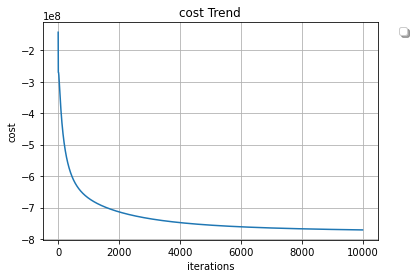

previous             0.979956
housing             -0.547031
month                0.054741
poutcome            -0.216283
contact_unknown     -0.872595
loan                -0.848788
campaign            -0.116779
job_retired          0.550035
job_student          0.405507
education            0.321129
marital             -0.100537
balance              0.331794
contact_telephone   -0.573099
job_unemployed      -0.637817
job_housemaid       -0.973470
job_entrepreneur    -1.398384
job_blue-collar     -0.112546
dtype: float64


In [111]:
lr1 = _LogisticRegression(tolerance= 0.0000001, learningRate =  0.1e-5, maxIteration = 10000)
lr1.run_model(X_train,np.array(y_train, dtype=int))

In [112]:
y_hat = lr1.predict(X_test)
accuracy,recall,precision = lr1.evaluate(np.array(y_test, dtype=int), y_hat)
f1 = 2*((precision*recall)/(precision+recall))
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.6793161750892354
recall :  0.7049677664012135
precision :  0.6667862266857962
f1 :  0.6853456221198156


We have not used SVM as the whole point of SMOTE was to make more use of the synthetic data being created, since SVM is a demanding algorithm, the team has decided not to execute SVM for this section.

### UNDER SAMPLING

In [113]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = data.sample(frac=1)

# amount of 1(i.e.'yes') is 5289 rows.We are taking only 2500 rows of each to reduce time consumed to train the models
yes_df = df.loc[df['y'] == 1][:2500]
no_df = df.loc[df['y'] == 0][:2500]

norm_df = pd.concat([yes_df, no_df])

# Shuffle dataframe rows
new_df = norm_df.sample(frac=1, random_state=42)

new_df.head()

,age,marital,education,default,balance,housing,loan,month,campaign,previous,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_telephone,contact_unknown
40862,0.181818,1,2,0,0.077198,1,0,2,2.0,1,...,0,0,0,0,0,1,0,0,0,0
16764,0.363636,1,1,0,0.153360,1,0,3,2.0,0,...,0,0,0,0,0,0,0,0,0,0
28611,0.506494,2,2,0,0.073502,1,1,11,3.0,1,...,0,0,0,0,0,1,0,0,0,0
41562,0.688312,2,3,1,0.084025,1,0,9,4.0,0,...,0,1,0,0,0,0,0,0,0,0
5803,0.246753,1,2,0,0.073938,0,0,1,2.0,0,...,0,0,0,0,0,0,0,0,0,1


In [114]:
X = new_df.drop('y', axis=1)
y = new_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

#### LOGISTIC REGRESSION

100%|██████████| 10000/10000 [00:27<00:00, 360.71it/s]
No handles with labels found to put in legend.


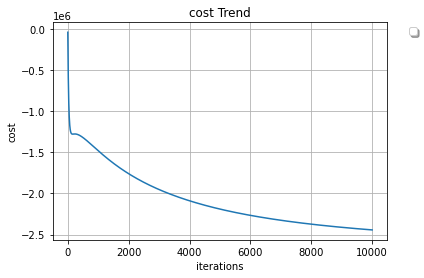

age                  0.017978
marital             -0.140649
education            0.114051
default             -0.118623
balance              0.009978
housing             -0.585472
loan                -0.384286
month                0.079678
campaign            -0.104702
previous             0.535630
poutcome             0.078916
job_blue-collar     -0.185231
job_entrepreneur    -0.081596
job_housemaid       -0.064833
job_management       0.064178
job_retired          0.242157
job_self-employed   -0.028808
job_services        -0.027258
job_student          0.106386
job_technician      -0.042698
job_unemployed       0.051266
job_unknown         -0.007930
contact_telephone    0.002130
contact_unknown     -0.728769
dtype: float64


In [115]:
lr_underSampling = _LogisticRegression(tolerance= 0.0000001, learningRate =  0.1e-5, maxIteration = 10000)
lr_underSampling.run_model(X_train,np.array(y_train, dtype=int))

In [116]:
y_hat = lr_underSampling.predict(X_test)
accuracy,recall,precision = lr_underSampling.evaluate(np.array(y_test, dtype=int), y_hat)
f1 = 2*((precision*recall)/(precision+recall))
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.658
recall :  0.6733067729083665
precision :  0.6550387596899225
f1 :  0.6640471512770136


#### SVM KERNEL RBF

In [117]:
for i in range(len(y_train)):
    if y_train.iloc[i] == 1:
        y_train.iloc[i] = 1
    else:
        y_train.iloc[i] = -1  

In [118]:
for i in range(len(y)):
    if y.iloc[i] == 1:
        y.iloc[i] = 1
    else:
        y.iloc[i] = -1 

In [119]:
model_under = KernelSvmClassifier(C=1000, kernel=GRBF)

In [120]:
model_under.fit(X_train.iloc[0:1000],y_train.head(1000))

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


In [121]:
y_pred=model_under.predict(X_test)

In [122]:
accuracy,recall,precision,f1 = evaluate_svm(y_test,y_pred)
        
print('Accuracy : ', accuracy)
print('recall : ', recall)
print('precision : ', precision)
print('f1 : ', f1)

Accuracy :  0.31
recall :  0.6175298804780877
precision :  0.6326530612244898
f1 :  0.625


#### LOGISTIC REGRESSION WITH CV

Data is again being read and different changes are made to it in preprocessing stage as we wanted to show how different approaches would change the evaluation metrics

In [123]:
url = 'https://drive.google.com/file/d/18Mdt-j-Jo1a05re0SNz2z8NZaxNher_p/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path,sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## EDA

Checking Output Variable

<AxesSubplot:xlabel='y', ylabel='count'>

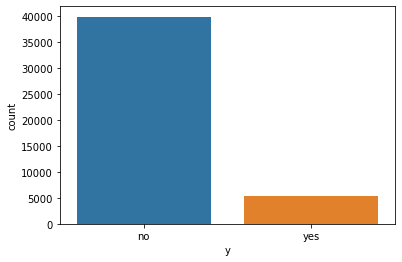

In [124]:
sns.countplot(data['y'])

The output variable is imbalanced with 11.5: 88.5
* Inorder to balance the data we either need to use over sampling or undersampling
* Oversampling can be sone by generating synthetic data using SMOTE, etc., or we can use Stratified Crossvalidation

In [125]:
data_numcols= data[['age','balance','campaign','previous','pdays']]
data_numcols.corr()

,age,balance,campaign,previous,pdays
age,1.000000,0.097783,0.004760,0.001288,-0.023758
balance,0.097783,1.000000,-0.014578,0.016674,0.003435
campaign,0.004760,-0.014578,1.000000,-0.032855,-0.088628
previous,0.001288,0.016674,-0.032855,1.000000,0.454820
pdays,-0.023758,0.003435,-0.088628,0.454820,1.000000


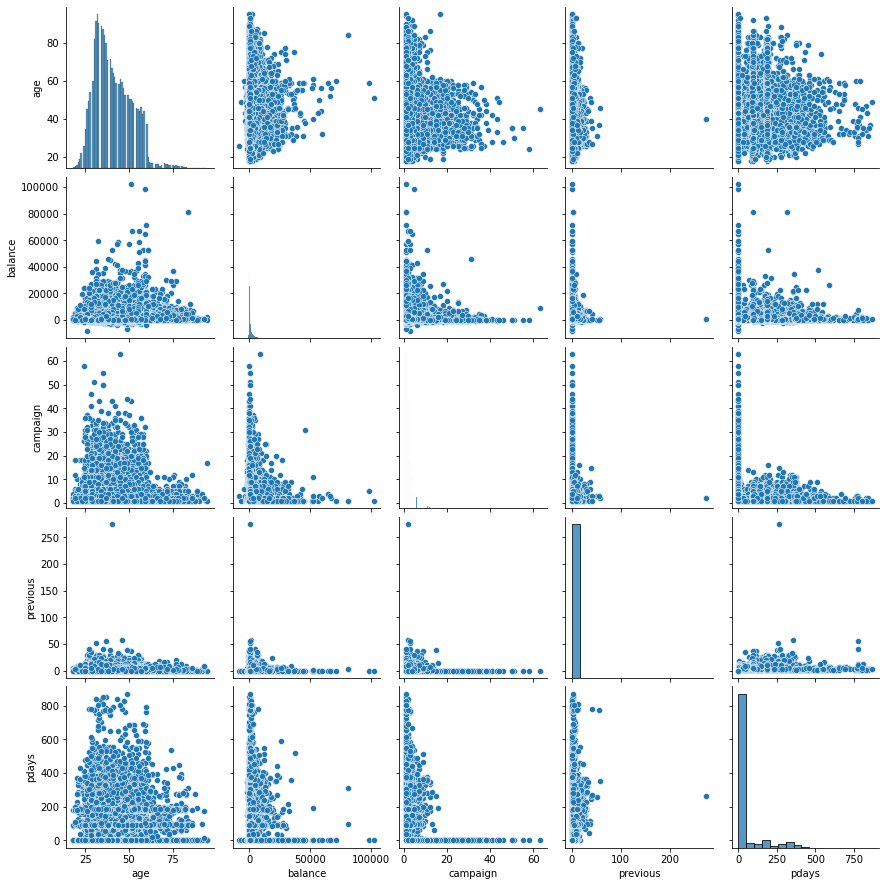

In [126]:
sns.pairplot(data_numcols)

Only pdays, previous are correlated with correlation coefficient of 0.45, but based on the defination
* pdays states that how many days from the last call to the client 
* previous says how may time client has been contacted

Text(0.5, 1.0, 'Previous')

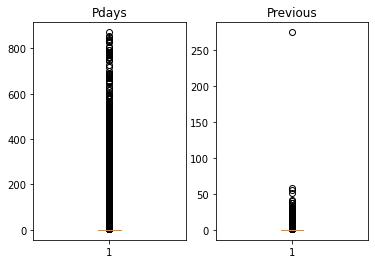

In [127]:
plt.subplot(1, 2, 1)
plt.boxplot(data['pdays'])
plt.title("Pdays")
plt.subplot(1, 2, 2)
plt.boxplot(data['previous'])
plt.title("Previous")

<AxesSubplot:xlabel='previous', ylabel='Density'>

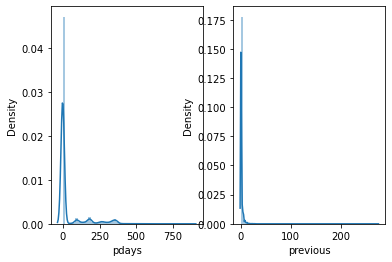

In [128]:
plt.subplot(1, 2, 1)
sns.distplot(data['pdays'])
plt.subplot(1, 2, 2)
sns.distplot(data['previous'])

If we see both boxplots and distribution plots we can see that these two are :
* Too skewed
* Most of the values are 0
* If we see the definition we can say these values indicate the same thing whether the client has been contacted or not, so we can use any one of them

Text(0.5, 1.0, 'Campaign')

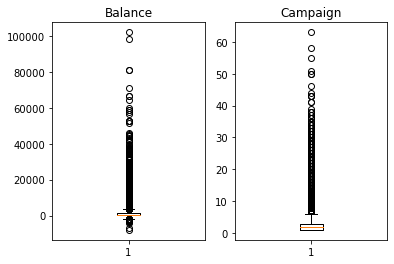

In [129]:
plt.subplot(1, 2, 1)
plt.boxplot(data['balance'])
plt.title("Balance")
plt.subplot(1, 2, 2)
plt.boxplot(data['campaign'])
plt.title("Campaign")

Text(0.5, 1.0, 'Age')

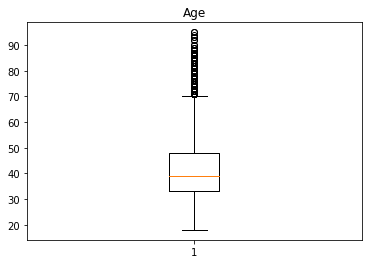

In [130]:
plt.boxplot(data['age'])
plt.title("Age")

Even these three are totally skewed and full of outliers. What can we do :
* We can centralize the data by imputing means in the outliers but as there are too many outliers we will be changing the whole data
* We can drop the rows with outliers, but we will be loosing lot of variance from the data
* We can standardize the data

## Relation with categorical variables

In [131]:
data['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

<AxesSubplot:xlabel='job', ylabel='count'>

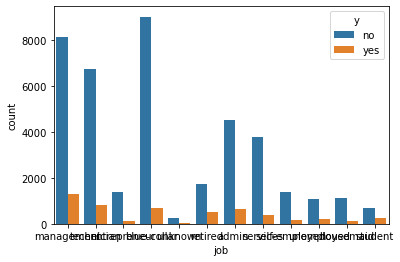

In [132]:
sns.countplot(data['job'], hue = data['y'])

<AxesSubplot:xlabel='month', ylabel='count'>

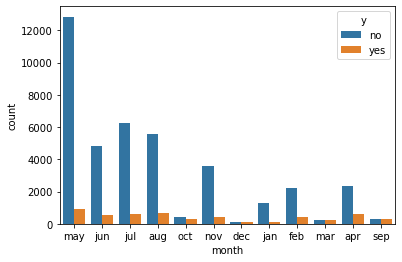

In [133]:
sns.countplot(data['month'], hue = data['y'])

<AxesSubplot:xlabel='marital', ylabel='count'>

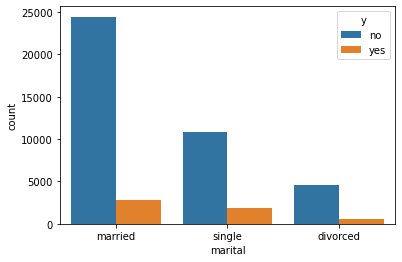

In [134]:
sns.countplot(data['marital'], hue = data['y'])

<AxesSubplot:xlabel='education', ylabel='count'>

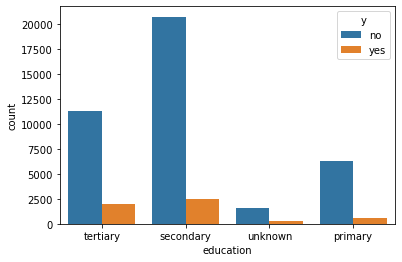

In [135]:
sns.countplot(data['education'], hue = data['y'])

<AxesSubplot:xlabel='default', ylabel='count'>

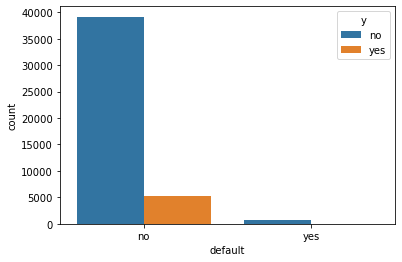

In [136]:
sns.countplot(data['default'], hue = data['y'])

<AxesSubplot:xlabel='housing', ylabel='count'>

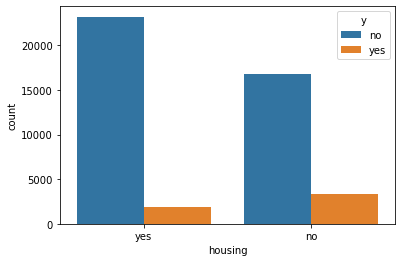

In [137]:
sns.countplot(data['housing'], hue = data['y'])

<AxesSubplot:xlabel='loan', ylabel='count'>

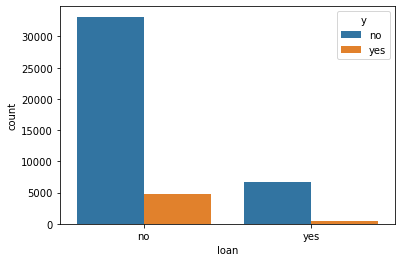

In [138]:
sns.countplot(data['loan'], hue = data['y'])

<AxesSubplot:xlabel='contact', ylabel='count'>

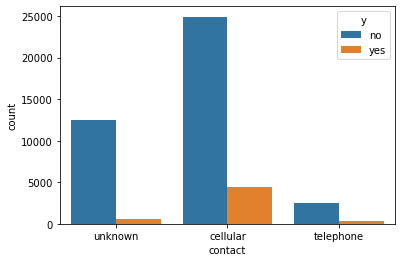

In [139]:
sns.countplot(data['contact'], hue = data['y'])

<AxesSubplot:xlabel='poutcome', ylabel='count'>

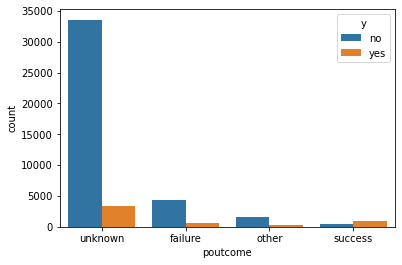

In [140]:
sns.countplot(data['poutcome'], hue = data['y'])

Except for the poutcome there are no patterns of relation between the variable and output. We can see that there are almost same proportions within in different categories of the variable.

What can be done:
* We can see the difference between proportions of each categories among variables and rank them creating a +ve ot -ve correlation
* Ordinal Encoding, but unknown relation will be formed between variables.
* One hot Encoding. As the date is not wide we can use one-hot encoding for all the variables.

In [141]:
data.loc[data['y']=="no",'y']= int(0)
data.loc[data['y']=="yes",'y']= int(1)
data['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [142]:
data = data.drop(['pdays','day','duration'],axis=1)
data.shape

(45211, 14)

In [143]:
##one-hot encoding
data = pd.get_dummies(data = data, columns = ['job', 'marital', 'education', 'default',  'housing', 'loan', 
                                              'contact', 'month', 'poutcome'],drop_first = True)

In [144]:
data.shape

(45211, 40)

In [145]:
##stratified splitting
tr_ts = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
for train_index, test_index in tr_ts.split(data, data["y"]):
    train = data.iloc[train_index]
    test  = data.iloc[test_index]

In [146]:
train.reset_index(inplace= True)
test.reset_index(inplace= True)

In [147]:
train_numcols= train[['age','balance','campaign','previous']]
test_numcols=test[['age','balance','campaign','previous']]

In [148]:
scaler=StandardScaler()
scaled_train = scaler.fit_transform(train_numcols)
scaled_test = scaler.transform(test_numcols)

In [149]:
scaled_train=pd.DataFrame(scaled_train)
scaled_train.head()

,0,1,2,3
0,1.604858,-0.387163,-0.571309,-0.241243
1,0.945324,0.522003,-0.245390,-0.241243
2,0.851105,-0.257649,0.406446,-0.241243
3,-1.315938,-0.417051,-0.571309,-0.241243
4,-0.279526,1.631385,-0.571309,-0.241243


In [150]:
scaled_train.isnull().values.any()

False

In [151]:
colnames=train_numcols.columns
colnames

Index(['age', 'balance', 'campaign', 'previous'], dtype='object')

In [152]:
scaled_train.columns=colnames
scaled_train.reset_index(inplace= True)
scaled_train.isnull().values.any()
scaled_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33908 entries, 0 to 33907
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     33908 non-null  int64  
 1   age       33908 non-null  float64
 2   balance   33908 non-null  float64
 3   campaign  33908 non-null  float64
 4   previous  33908 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.3 MB


In [153]:
scaled_test=pd.DataFrame(scaled_test)
scaled_test.head()

,0,1,2,3
0,0.003132,1.507013,-0.245390,-0.241243
1,1.699078,-0.408695,-0.571309,1.002308
2,-0.373745,-0.440511,0.732365,-0.241243
3,0.003132,-0.469435,1.058283,-0.241243
4,-1.315938,1.124257,-0.245390,1.416825


In [154]:
scaled_test.isnull().values.any()

False

In [155]:
colnames=train_numcols.columns
colnames

Index(['age', 'balance', 'campaign', 'previous'], dtype='object')

In [156]:
scaled_test.columns=colnames

In [157]:
scaled_test.reset_index(inplace= True)

In [158]:
scaled_test.isnull().values.any()

False

In [159]:
scaled_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11303 entries, 0 to 11302
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     11303 non-null  int64  
 1   age       11303 non-null  float64
 2   balance   11303 non-null  float64
 3   campaign  11303 non-null  float64
 4   previous  11303 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 441.6 KB


In [160]:
train = train.drop(['age','balance','campaign','previous'],axis=1)
test = test.drop(['age','balance','campaign','previous'],axis=1)

In [161]:
train=train.merge(scaled_train,on='index')

In [162]:
test=test.merge(scaled_test,on='index')

In [163]:
test['y'].value_counts()

0    2729
1     110
Name: y, dtype: int64

In [164]:
train=train.drop(['index'],axis=1)
test=test.drop(['index'],axis=1)

In [165]:
train['y'].astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
25461    1
25462    0
25463    0
25464    0
25465    0
Name: y, Length: 25466, dtype: int64

In [166]:
class LogisticRegression:
    def __init__(self, train,test,learningRate, tolerance,maxIteration = 50000):
        self.learningRate = learningRate
        self.tolerance = tolerance
        self.maxIteration = maxIteration
        self.train = train
        self.X_test = test
        
    def dataset_reader(self):
        train_df = self.train
        
        y_train = train_df.pop('y')
        X_train = train_df
        
        X_train = np.array(X_train, dtype = np.float64)
        X_test = np.array(self.X_test, dtype = np.float64)
        
        
        return X_train,X_test, y_train
    
    def add_x0(self, X):
        return np.column_stack([np.ones(X.shape[0], 1), X])
        
    def sigmoid(self, z):
        z = np.array(z,dtype = float)
        sig = 1/(1+np.exp(-z))
        
        return sig
    
    
    def cost_function(self, X, y):
        
        sig = self.sigmoid(X.dot(self.w))
        #pred = y * np.log(sig)+(1-y)*np.log(1 - sig)
        #cost = pred.sum()
        
        # or:
        pred_ = np.log(np.ones(X.shape[0]) + np.exp(sig))- X.dot(self.w).dot(y)
        
        cost = pred_.sum()
        
        return cost
    
    def gradient(self, X, y):
        
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig - y).dot(X)
        
        return grad
    
    def gradient_descent(self, X, y):
        
        cost_sequence = []
        last_cost = float('inf')
        tolerance_counter = 0
        
        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_cost = self.cost_function(X, y)
            diff = last_cost - current_cost
            last_cost = current_cost
            cost_sequence.append(current_cost)
            
            if diff < self.tolerance:
                tolerance_counter += 1
                #print('The model stopped - no further improvement')
                if tolerance_counter == 10:
                    break
        
    def predict(self, X):
        print(X.dot)
        sig = self.sigmoid(X.dot(self.w))
        return sig
    
    

    def run_model(self):
        self.X_train,self.X_test, self.y_train = self.dataset_reader()
        
        
        self.w = np.ones(self.X_train.shape[1], dtype = np.float64)*0
        self.gradient_descent(self.X_train, self.y_train)
        #print(self.w)
        #predicting on test data
        y_hat = self.predict(self.X_test)
        return y_hat


In [167]:
train_1 = train[train['y'] == 1] ##minority class- 5000
train_2 = train[train['y'] == 0]  ##majority class -40,000
x = train_1.shape[0]
y = train_2.shape[0]
n = int(y/(x*2))
k = int(y/n)
y_pred = pd.DataFrame()
y_pred["test"] = test['y']
test.pop('y')
for i in range(n):
    print(i)
    fold = train_2.iloc[k*i:k*(i+1),]
    frames = [fold,train_1]
    fold = pd.concat(frames)
    k1 = LogisticRegression(train = fold, test = test, learningRate = 0.6e-5, tolerance = 0.1 )
    z = k1.run_model()
    y_pred[i] = z
    
y_pred  


  0%|          | 0/50000 [00:00<?, ?it/s]

0


  0%|          | 3/50000 [00:00<30:49, 27.03it/s]

<built-in method dot of numpy.ndarray object at 0x7fc83a2a2a30>
1


  0%|          | 3/50000 [00:00<31:20, 26.59it/s]

<built-in method dot of numpy.ndarray object at 0x7fc49157c080>
2


  0%|          | 3/50000 [00:00<31:52, 26.14it/s]

<built-in method dot of numpy.ndarray object at 0x7fc83a4b6120>
3


  0%|          | 3/50000 [00:00<30:56, 26.92it/s]

<built-in method dot of numpy.ndarray object at 0x7fc83a4b6210>
4


  0%|          | 3/50000 [00:00<31:21, 26.57it/s]

<built-in method dot of numpy.ndarray object at 0x7fc83a4b6210>
5


  0%|          | 3/50000 [00:00<31:09, 26.74it/s]

<built-in method dot of numpy.ndarray object at 0x7fc83a4b6300>
6


  0%|          | 10/50000 [00:00<41:14, 20.20it/s]

<built-in method dot of numpy.ndarray object at 0x7fc83a4b6210>


,test,0,1,2,3,4,5,6
0,0,0.452940,0.453161,0.451201,0.450703,0.451803,0.452441,0.451186
1,0,0.450199,0.455698,0.451239,0.452392,0.454464,0.453244,0.451117
2,0,0.461335,0.459790,0.457966,0.458859,0.458722,0.459724,0.459191
3,0,0.457550,0.463612,0.457856,0.459583,0.461952,0.461782,0.459011
4,0,0.444740,0.444009,0.443844,0.443606,0.444504,0.444127,0.443398
...,...,...,...,...,...,...,...,...
2834,0,0.450619,0.447662,0.448952,0.447688,0.448839,0.447816,0.448383
2835,0,0.464527,0.464131,0.463955,0.463280,0.464506,0.463882,0.463881
2836,0,0.457911,0.456960,0.455137,0.455466,0.456108,0.456666,0.456220
2837,0,0.463662,0.464847,0.464403,0.463236,0.464780,0.463250,0.463048


In [168]:
y_pred['v'] = (y_pred[0]+y_pred[1]+y_pred[2]+y_pred[3]+y_pred[4]+y_pred[5]+y_pred[6])/7

In [169]:
y_pred.loc[y_pred[0]>0.447,'y_prediction']=0
y_pred.loc[y_pred[0]<=0.447,'y_prediction']=1
y_pred['y_prediction'].value_counts()

0.0    2650
1.0     189
Name: y_prediction, dtype: int64

In [170]:
def evaluate1(y, y_hat):
        y = (y==1)
        y_hat = (y_hat == 1)
        
        accuracy = ( (y == y_hat).sum())/ y.size
        precission = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum()/ y.sum()
        
        return accuracy, recall, precission

In [171]:
acc,pre,rec = evaluate1(y_pred['test'],y_pred['y_prediction'])

In [172]:
acc

0.8996125396266291

In [173]:
pre

0.06363636363636363

In [174]:
rec

0.037037037037037035

#### NEURAL NETWORKS WITH KERAS AND TENSORFLOW

In [175]:
##stratified splitting
tr_ts = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
for train_index, test_index in tr_ts.split(data, data["y"]):
    train = data.iloc[train_index]
    test  = data.iloc[test_index]

In [176]:
train.reset_index(inplace= True)
test.reset_index(inplace= True)

In [177]:
train_numcols= train[['age','balance','campaign','previous']]
test_numcols=test[['age','balance','campaign','previous']]

In [178]:
scaler=StandardScaler()

scaled_train = scaler.fit_transform(train_numcols)
scaled_test = scaler.transform(test_numcols)

In [179]:
scaled_train=pd.DataFrame(scaled_train)
scaled_train.head()

,0,1,2,3
0,1.604858,-0.387163,-0.571309,-0.241243
1,0.945324,0.522003,-0.245390,-0.241243
2,0.851105,-0.257649,0.406446,-0.241243
3,-1.315938,-0.417051,-0.571309,-0.241243
4,-0.279526,1.631385,-0.571309,-0.241243


In [180]:
colnames=train_numcols.columns
colnames

Index(['age', 'balance', 'campaign', 'previous'], dtype='object')

In [181]:
scaled_train.columns=colnames

In [182]:
scaled_train.reset_index(inplace= True)

In [183]:
scaled_train.isnull().values.any()

False

In [184]:
scaled_test=pd.DataFrame(scaled_test)
scaled_test.head()

,0,1,2,3
0,0.003132,1.507013,-0.245390,-0.241243
1,1.699078,-0.408695,-0.571309,1.002308
2,-0.373745,-0.440511,0.732365,-0.241243
3,0.003132,-0.469435,1.058283,-0.241243
4,-1.315938,1.124257,-0.245390,1.416825


In [185]:
colnames=train_numcols.columns
colnames

Index(['age', 'balance', 'campaign', 'previous'], dtype='object')

In [186]:
scaled_test.columns=colnames

In [187]:
scaled_test.reset_index(inplace= True)

In [188]:
train = train.drop(['age','balance','campaign','previous'],axis=1)
test = test.drop(['age','balance','campaign','previous'],axis=1)

In [189]:
train=train.merge(scaled_train,on='index')

In [190]:
test=test.merge(scaled_test,on='index')

In [191]:
train=train.drop(['index'],axis=1)
test=test.drop(['index'],axis=1)

In [192]:
train['y'].astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
25461    1
25462    0
25463    0
25464    0
25465    0
Name: y, Length: 25466, dtype: int64

In [193]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2839 entries, 0 to 2838
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   y                    2839 non-null   object 
 1   job_blue-collar      2839 non-null   uint8  
 2   job_entrepreneur     2839 non-null   uint8  
 3   job_housemaid        2839 non-null   uint8  
 4   job_management       2839 non-null   uint8  
 5   job_retired          2839 non-null   uint8  
 6   job_self-employed    2839 non-null   uint8  
 7   job_services         2839 non-null   uint8  
 8   job_student          2839 non-null   uint8  
 9   job_technician       2839 non-null   uint8  
 10  job_unemployed       2839 non-null   uint8  
 11  job_unknown          2839 non-null   uint8  
 12  marital_married      2839 non-null   uint8  
 13  marital_single       2839 non-null   uint8  
 14  education_secondary  2839 non-null   uint8  
 15  education_tertiary   2839 non-null   u

In [194]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Dense(units=128),
  
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [195]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=keras.metrics.Precision())

In [ ]:
train_1 = train[train['y'] == 1] ##minority class- 5000
train_2 = train[train['y'] == 0]  ##majority class -40,000
x = train_1.shape[0]
y = train_2.shape[0]
n = int(y/(x*2))
k = int(y/n)
y_pred = pd.DataFrame()
y_pred["test"] = test['y']
test.pop('y')
z=0
for i in range(n):
    print(i)
    fold = train_2.iloc[k*i:k*(i+1),]
    frames = [fold,train_1]
    fold = pd.concat(frames)
    X_train = fold
    y_train = X_train.pop('y')
    k1 = model.fit(X_train, np.asarray(y_train).astype('float32'), epochs = 750)
    z = model.predict(test)
    y_pred[i] = z
    
y_pred    

0
Epoch 1/750

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

157/157 [==============================] - 0s 776us/step - loss: 0.6093 - precision: 0.5452
Epoch 2/750
157/157 [==============================] - 0s 685us/step - loss: 0.5810 - precision: 0.6737
Epoch 3/750
157/157 [==============================] - 0s 663us/step - loss: 0.5746 - precision: 0.6749
Epoch 4/750
157/157 [==============================] - 0s 657us/step - loss: 0.5671 - precision: 0.7135
Epoch 5/750
157/157 [==============================] - 0s 673us/step - loss: 0.5610 - prec

In [ ]:
y_pred['v'] = (y_pred[0]+y_pred[1]+y_pred[2]+y_pred[3]+y_pred[4]+y_pred[5]+y_pred[6])/7

The cut off is kept low so that the people who may be interested would not be neglected as the model predicts 'no'. Over multiple trainings, the cut off has been decided as 0.2.

In [ ]:
y_pred.loc[y_pred[0]<0.2,'y_prediction']=0
y_pred.loc[y_pred[0]>=0.2,'y_prediction']=1
#y_pred['y_prediction'].value_counts()

In [ ]:
acc,pre,rec = evaluate1(y_pred['test'],y_pred['y_prediction'])

In [ ]:
acc

In [ ]:
pre

In [ ]:
rec